# Pearl Coding Assignment

Guy Davidson -- IL181.011 -- Professor Patrick Lam -- 2018-11-03

The full notebook is available online here:

https://github.com/guydav/minerva/blob/master/tutorials/causality_csr/pearl/pearl.ipynb

And will probably be easier to read there than in PDF form.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [439]:
import pandas as pd
# import modin.pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import display, Markdown, Latex

import networkx as nx
import sklearn
from sklearn.neighbors import KernelDensity
import statsmodels.api as sm
from collections import namedtuple, OrderedDict
from scipy import stats

matplotlib.style.use('ggplot')

Keeping an ordered dictionary of results, for the final plot (5)

In [440]:
labels_to_results = OrderedDict()

## Problem setup

Researchers at the Mischevious Institution of Nervewrecking Education Regarding Villainous Achievement are attempting to investigte the effect of expensive tutoring (T) on grades (G). They have identified the following model for grades:

* $M$: the motivation a student might have, affecting both their grades and the odds they will pursue tutoring ($M = 1$ high motivation, $M = 0$ low motivation)
* $T$: what sort of tutoring the student opted for ($T = 1$ expensive, $T = 0$ cheap)
* $S$: the skill level of the tutor assigned to the student
* $G$: the grade received by the student (assuming the institution eventually curved to assign letter grades)
* $R$: the rating the student gave the course, influnced by whether or not they pursued tutoring and by their grade

The following DAG describes their model. Note that the graph contains:
* A fork: $T \leftarrow M \rightarrow G$
* A chain: $T \rightarrow S \rightarrow G$
* A collider: $T \rightarrow R \leftarrow G$

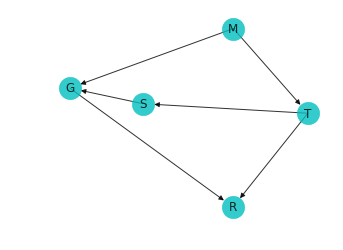

In [3]:
# graph_data = {'A': ['M', 'T'], 'M': ['G'], 'T': ['G', 'S', 'P'], 'S': ['G'], 'G': ['P']}
graph_data = {'M': ['G', 'T'], 'T': ['S', 'R'], 'S': ['G'], 'G': ['R']}

    
graph = nx.from_dict_of_lists(graph_data, nx.DiGraph())

layout = nx.layout.spring_layout(graph, seed=10)

plt.figure(figsize=(4, 3))
nx.draw(graph, layout, with_labels=True, node_color='c', alpha=0.8, node_size=500)

Let us define a set of equations that govern the model: 

\begin{align*}
M &\sim P(M = 1) = 0.5 \\
T &\sim P(T = 1|M) = 0.4 + 0.4M \\
% T &= 10 + 10M + \mathcal{N}(0, 1) \\
% S &= T + \mathcal{N}(0, 3) \\
S &= 10T + \mathcal{N}(0, 3) \\
G &= 50 + 20M + S + \mathcal{N}(0, 5) \\
R &= 0.5G + T
\end{align*}

Note that under this model, the true effect of T on G is 10, as the effect of T on S is one, and the effect of S on G is one. Let's see if we can recover it from simulated data:


In [202]:
N_POINTS = 1000

m = np.random.binomial(1, 0.5, N_POINTS)
t = np.random.binomial(1, 0.4 * m + 0.4, N_POINTS)
# t = 10 + 10 * m + np.random.normal(0, 1, N_POINTS)
s = 10 * t + np.random.normal(0, 3, N_POINTS)
g = 50 + 20 * m + s + np.random.normal(0, 5, N_POINTS)
r = 0.5 * g + t

data = pd.DataFrame(np.stack((m, t, s, g, r)).T, columns=('M', 'T', 'S', 'G', 'R'))
data[:10]

,M,T,S,G,R
0,0.0,1.0,14.168374,66.232499,34.116249
1,0.0,0.0,4.120250,55.268195,27.634097
2,0.0,0.0,1.263800,46.854313,23.427156
3,1.0,1.0,11.320029,74.386085,38.193042
4,0.0,0.0,-1.264570,51.063135,25.531568
5,1.0,0.0,2.631384,72.700031,36.350016
6,0.0,1.0,10.335366,59.565821,30.782910
7,0.0,0.0,-0.208293,49.090336,24.545168
8,1.0,1.0,9.217128,70.551901,36.275951
9,0.0,1.0,9.114248,52.886888,27.443444


Let's plot the varibles of interest, just to visualize the problem a bit:

Text(0.5,1,'G | M, T')

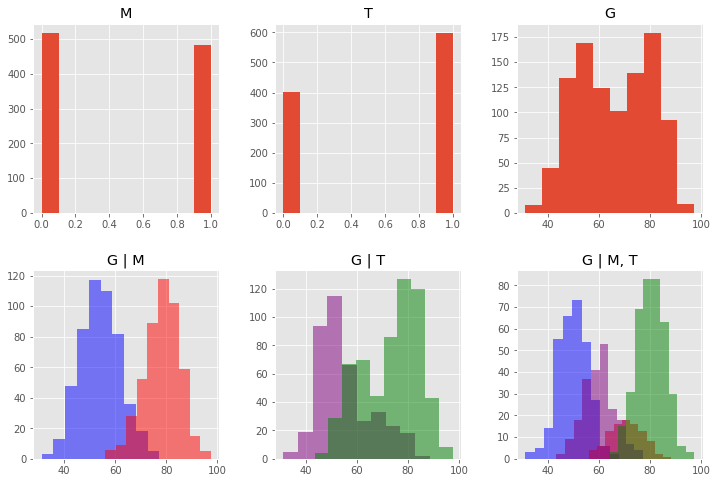

In [203]:
plt.figure(figsize=(12, 8))
NROWS = 2
NCOLS = 3

data.hist('M', ax=plt.subplot(NROWS, NCOLS, 1))
data.hist('T', ax=plt.subplot(NROWS, NCOLS, 2))
data.hist('G', ax=plt.subplot(NROWS, NCOLS, 3))
g_on_m_ax = plt.subplot(NROWS, NCOLS, 4)
data[data['M'] == 0].hist('G', alpha=0.5, color='blue', ax=g_on_m_ax)
data[data['M'] == 1].hist('G', alpha=0.5, color='red', ax=g_on_m_ax)
g_on_m_ax.set_title('G | M')
g_on_t_ax = plt.subplot(NROWS, NCOLS, 5)
data[data['T'] == 0].hist('G', alpha=0.5, color='purple', ax=g_on_t_ax)
data[data['T'] == 1].hist('G', alpha=0.5, color='green', ax=g_on_t_ax)
g_on_t_ax.set_title('G | T')
g_on_both_ax = plt.subplot(NROWS, NCOLS, 6)
data[np.logical_and(data['M'] == 0, data['T'] == 0)].hist('G', alpha=0.5, color='blue', ax=g_on_both_ax)
data[np.logical_and(data['M'] == 1, data['T'] == 0)].hist('G', alpha=0.5, color='red', ax=g_on_both_ax)
data[np.logical_and(data['M'] == 0, data['T'] == 1)].hist('G', alpha=0.5, color='purple', ax=g_on_both_ax)
data[np.logical_and(data['M'] == 1, data['T'] == 1)].hist('G', alpha=0.5, color='green', ax=g_on_both_ax)
g_on_both_ax.set_title('G | M, T')

The above nicely demonstrates that conditioning on M separates the cases much better than conditioning on T alone - let's see if we can recover this:

We want to implement the backdoor criterion, given by 

$$ P(Y = y \mid do(X = x)) = \sum_z P(Y = y \mid X = x, Z = z) P(Z = z) $$

In our case, the effect of interest is on $G$, the intevention of interest is $T = 1$ (opting for an expensive tutor), and the variable satisfying the backdoor criterion is $M$, the motivation. 

To implement this quantity, we need to compute the quantities $P(Y = y \mid X = x, Z = z)$. I can imagine two ways to do so. One is to compute kernel density estimators for $Y$ under each set of conditions ($M \in \{0, 1\} \times T \in \{0, 1\}$), and then weight these kernel densities by $P(M = m)$, which actually results in the full $P(Y \mid do(X = x)$. A second approach might be to bin Y to some range, and estimate it for every such range, effectively estimating the integral over such a distribution by a sum.

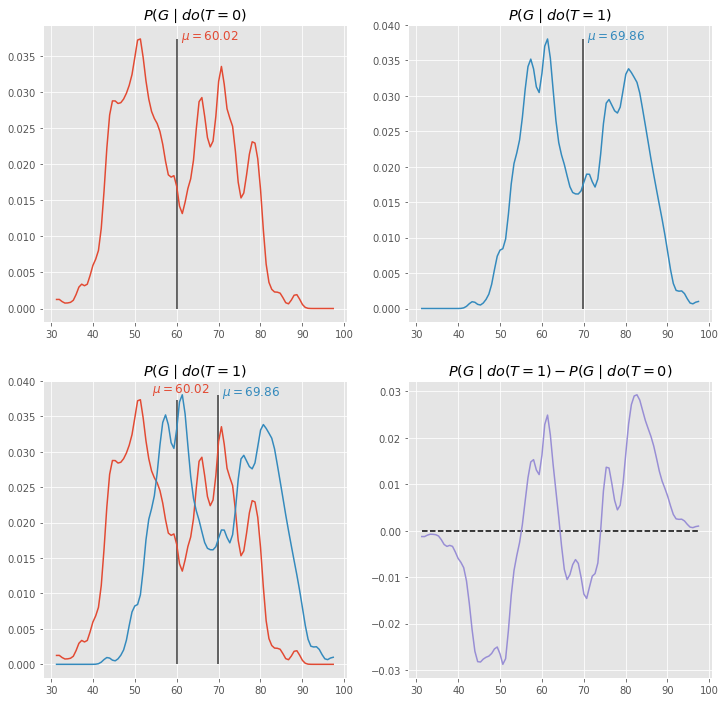

The difference in means is:

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

The variances (second moment estimates) and standard deviations are:

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

The middle 50% of each distribution is:

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [412]:
def compute_and_plot_backdoor_kernel(data, output, treatment, backdoor):
    backdoor_treat_0, backdoor_treat_1, plot_values, dx = \
        backdoor_kernel_method(data, output, treatment, backdoor)
    
    plt.figure(figsize=(12, 12))
    # P(Y | do(X = 0))
    top_left_ax = plt.subplot(2, 2, 1)
    plot_density(top_left_ax, backdoor_treat_0, 0, plot_values, output, treatment)
    
    # P(Y | do(X = 1))    
    top_right_ax = plt.subplot(2, 2, 2)
    plot_density(top_right_ax, backdoor_treat_1, 1, plot_values, output, treatment,
                 color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
    
    # Superimposed
    bottom_left_ax = plt.subplot(2, 2, 3)
    plot_density(bottom_left_ax, backdoor_treat_0, 0, plot_values, output, treatment, 
                 offset_x=-6, offset_y=0.001)
    plot_density(bottom_left_ax, backdoor_treat_1, 1, plot_values, output, treatment,
                 color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
    
    # Difference between them
    density_diff = backdoor_treat_1.density_values - backdoor_treat_0.density_values
    bottom_right_ax = plt.subplot(2, 2, 4)
    bottom_right_ax.plot(plot_values, density_diff, 
                         color=plt.rcParams['axes.prop_cycle'].by_key()['color'][2])
    bottom_right_ax.set_title(f'$P({output} \\mid do({treatment} = {1}) - P({output} \\mid do({treatment} = {0}) $')
    bottom_right_ax.hlines(0, plot_values[0], plot_values[-1], linestyle='--')
            
    plt.show()
    display_output(output, treatment, backdoor, backdoor_treat_0, backdoor_treat_1)
    
    return backdoor_treat_0, backdoor_treat_1, plot_values, dx
    
def backdoor_kernel_method(data, output, treatment, backdoor):
    backdoor_1_prob = len(data[data[backdoor] == 1][backdoor]) / len(data)
    
    densities = {}
    for treat_val in (0, 1):
        for backdoor_val in (0, 1):
            cond_output_data = data[np.logical_and(data[treatment] == treat_val, data[backdoor] == backdoor_val)][output]
            # Handling the case of one sub-sample being of size zero, which happens with truncated data
            if cond_output_data is None or len(cond_output_data) == 0:
                kde = None
            else:
                kde = KernelDensity().fit(cond_output_data[:, np.newaxis])
            densities[treat_val, backdoor_val] = kde
            
    output_min = data[output].min()
    output_max = data[output].max()
    plot_values = np.linspace(output_min, output_max , 100)
    dx = plot_values[1] - plot_values[0]
    
    BackdoorOutput = namedtuple('BackdoorOutput', ('density_values', 'mean', 'cdf', 'var', 'q1', 'q3'))
    values_treat_0 = compute_backdoor_density(densities, 0, backdoor_1_prob, plot_values, dx)
    backdoor_treat_0 = None
    if values_treat_0 is not None:
        backdoor_treat_0 = BackdoorOutput(*values_treat_0)

    values_treat_1 = compute_backdoor_density(densities, 1, backdoor_1_prob, plot_values, dx)
    backdoor_treat_1 = None
    if values_treat_1 is not None:
        backdoor_treat_1 = BackdoorOutput(*values_treat_1)
    
    return backdoor_treat_0, backdoor_treat_1, plot_values, dx
    
    
def compute_backdoor_density(densities, treat_val, backdoor_1_prob, plot_values, dx):
    backdoor_0_density = densities[treat_val, 0]
    backdoor_1_density = densities[treat_val, 1]
    
    # Handling the case of one sub-sample being of size zero, which happens with truncated data
    density_values = None
    if backdoor_0_density is not None:
        density_values = np.exp(backdoor_0_density.score_samples(plot_values[:, np.newaxis])) * (1 - backdoor_1_prob)
        
    if backdoor_1_density is not None:
        vals = np.exp(backdoor_1_density.score_samples(plot_values[:, np.newaxis])) * backdoor_1_prob
        if density_values is None:
            density_values = vals
            
        else:
            density_values += vals
    if density_values is None:
        return None
    
    mean = np.dot(density_values, plot_values) * dx
    #     med = plot_values[np.argmin(abs(cdf - 0.5))]
    cdf = np.cumsum(density_values * dx)
    var = np.dot(density_values, np.square(plot_values - mean)) * dx
    q1 = plot_values[np.argmin(abs(cdf - 0.25))]
    q3 = plot_values[np.argmin(abs(cdf - 0.75))]
    
    return density_values, mean, cdf, var, q1, q3
    
    
def plot_density(ax, backdoor_output, treat_val, plot_values, output, treatment,
                 color=None, offset_x=1, offset_y=0, **kwargs):
    if color is None:
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]

    ax.plot(plot_values, backdoor_output.density_values, color=color, **kwargs)
    ax.vlines(backdoor_output.mean, 0, max(backdoor_output.density_values), alpha=0.75)
    ax.text(backdoor_output.mean + offset_x, max(backdoor_output.density_values) + offset_y, 
            f'$\\mu = {backdoor_output.mean:.2f}$', fontsize=12, color=color)
#     ax.vlines(med, 0, max(density_values), alpha=0.75)
#     ax.text(mean + np.sign(mean - med) * 5, max(density_values), 
#             f'$\\mu = {mean:.2f}$', fontsize=12, color=color)
#     ax.text(med + np.sign(med - mean) * 5, max(density_values), 
#             f'$M = {med:.2f}$', fontsize=12, color=color)
    ax.set_title(f'$P({output} \\mid do({treatment} = {treat_val}) $')
    
    
def display_output(output, treatment, backdoor, backdoor_treat_0, backdoor_treat_1):
    display(Markdown(f'The difference in means is:'))
    display(Latex(f'$E[P({output} | do({treatment} = 1)] - E[P({output} | do({treatment} = 0)]$'))
    display(Latex(f'$= {backdoor_treat_1.mean:.3f} - {backdoor_treat_0.mean:.3f} = {backdoor_treat_1.mean - backdoor_treat_0.mean:.3f}$'))
    display(Markdown(f'The variances (second moment estimates) and standard deviations are:'))
    display(Latex(f'$Var[P({output} | do({treatment} = 0)] = {backdoor_treat_0.var:.3f}, \\sqrt{{Var}} = {backdoor_treat_0.var ** 0.5:.3f} $'))
    display(Latex(f'$Var[P({output} | do({treatment} = 1)] = {backdoor_treat_1.var:.3f}, \\sqrt{{Var}} = {backdoor_treat_1.var ** 0.5:.3f} $'))
    display(Markdown('The middle 50% of each distribution is:'))
    display(Latex(f'$ P({output} | do({treatment} = 0): [{backdoor_treat_0.q1:.3f}, {backdoor_treat_0.q3:.3f}] $'))
    display(Latex(f'$ P({output} | do({treatment} = 1): [{backdoor_treat_1.q1:.3f}, {backdoor_treat_1.q3:.3f}] $'))
    

backdoor_treat_0, backdoor_treat_1, plot_values, dx = compute_and_plot_backdoor_kernel(data, 'G', 'T', 'M')

## Computing for a particular outcome (grade)

The difference in distribution means is one way to get the backdoor estimation. If, as in Pearl's notation, we care about the effect for a particular outcome, $P(Y = y \mid do(X = x))$ rather than $P(Y \mid do(X = x))$, we can compute that as well: 

In [237]:
def difference_for_output_value(out_val, treat_0_values, treat_1_values, plot_values,
                               output='G', treatment='T'):
    if out_val < plot_values[0] or out_val > plot_values[-1]:
        print(f'Warning: queried output value {out_val} is outside of the support [{plot_values[0]}, plot_values[1]]')
        
    index = np.argmin(abs(plot_values - out_val))
    diff = treat_1_values[index] - treat_0_values[index]
    display(Markdown(f'For an output of {out_val}, the closest computed value was {plot_values[index]:.3f}:'))
    display(Latex(f'$P({output} = {out_val} | do({treatment} = 1)) - P({output} - {out_val} | do({treatment} = 0))$'))
    display(Latex(f'$\\approx P({output} = {plot_values[index]:.3f} | do({treatment} = 1)] - P({output} - {plot_values[index]:.3f} | do({treatment} = 0)]$'))
    display(Latex(f'$= {treat_1_values[index]:.3f} - {treat_0_values[index]:.3f} = {diff:.3f}$'))
    return diff
    
diff = difference_for_output_value(85, treat_0_values, treat_1_values, plot_values)
display(Markdown(f'Which we can interpret as (I hope):'))
direction = diff > 0 and 'increases' or 'decreases'
display(Markdown(f'If our target grade is 85, opting for expensive tutoring {direction} our probability by {diff:.3f} '))

For an output of 85, the closest computed value was 84.721:

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Which we can interpret as (I hope):

If our target grade is 85, opting for expensive tutoring increases our probability by 0.024 

## What if we care about a range of grades?

If our student particularly cares about a range of grades, we can also integrate this difference (which is equivalent to integrating each separately and substracting the difference). Perhaps our villain wants to pursue post-gradate studies at the Harrowing Assembly Responsible for Villainous Action and Responsible Destuction, who require grades of 75 and above:

In [245]:
def difference_for_output_range(out_min, out_max, treat_0_values, treat_1_values, plot_values,
                               output='G', treatment='T'):
    if out_min < plot_values[0] or out_max > plot_values[-1]:
        print(f'Warning: queried output range [{out_min}, {out_max}] is outside of the support [{plot_values[0]}, {plot_values[1]}]')
        
    start_index = np.argmin(abs(plot_values - out_min))
    end_index = np.argmin(abs(plot_values - out_max))
    diff = np.sum(treat_1_values[start_index:end_index + 1] - treat_0_values[start_index:end_index + 1])
    display(Markdown(f'For an output range [{out_min}, {out_max}], the closest computed range was [{plot_values[start_index]:.3f}, {plot_values[end_index]:.3f}]:'))
    display(Latex(f'$P({out_min} \\leq {output} \\leq {out_max} | do({treatment} = 1)) - P({out_min} \\leq {output} \\leq {out_max} | do({treatment} = 0))$'))
    display(Latex(f'$\\approx P({plot_values[start_index]:.3f} \\leq {output} \\leq {plot_values[end_index]:.3f} | do({treatment} = 1)) - P({plot_values[start_index]:.3f} \\leq {output} \\leq {plot_values[end_index]:.3f} | do({treatment} = 0))  $'))
    display(Latex(f'$= \\sum_{{ {output.lower()} \\in [{plot_values[start_index]:.3f}, {plot_values[end_index]:.3f}] }} \\left[ P( {output} = {output.lower()} \\mid do({treatment} = 1) ) - P( {output} = {output.lower()} \\mid do({treatment} = 0) ) \\right]$'))
    display(Latex(f'$= {diff:.3f}$'))
    return diff
    
diff = difference_for_output_range(75, 100, treat_0_values, treat_1_values, plot_values)

For an output range [75, 100], the closest computed range was [74.697, 97.417]:

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Let's think of another way to represent the uncertainty in the treatment effect:

The difference in distribution means is a scalar, and the distributions overlap enough to make it hard to use their middle 50%'s as meaningful confidence intervals. So what can we do?

We can bootstrap! What if we repeatedly subsample the data we have, and generate a sampling distribution for the average treatment effect. We use the initial seed argument to produce reproducible results:


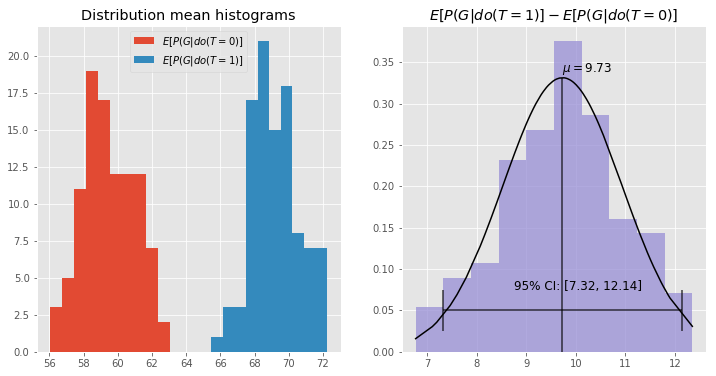

In [441]:
def boostrap_backdoor_estimate(data, output, treatment, backdoor, 
                               n_bootstrap_samples, n_subsamples, seed_0=0, max_bootsrap_samples=10000):
    bootstrap_results = []
    i = 0
    
    while len(bootstrap_results) < n_bootstrap_samples and i < max_bootsrap_samples:
        bootstrap_data = data.sample(n_subsamples, random_state=seed_0 + i)
        result = backdoor_kernel_method(bootstrap_data, output, treatment, backdoor)
        if result[0] is not None and result[1] is not None:
            bootstrap_results.append(result)
            
        i += 1
        
    if len(bootstrap_results) < n_bootstrap_samples:
        print(f'Warning: failed to generate valid {n_bootstrap_samples} samples in {max_bootsrap_samples} attempts. Aborting...')
        return
        
    treat_0_means = np.array([tup[0].mean for tup in bootstrap_results])
    treat_1_means = np.array([tup[1].mean for tup in bootstrap_results])
    
    plt.figure(figsize=(12, 6))
    left_ax = plt.subplot(1, 2, 1)
    left_ax.hist(treat_0_means, label=f'$E[P({output} | do({treatment} = 0)]$')
    left_ax.hist(treat_1_means, label=f'$E[P({output} | do({treatment} = 1)]$')
    left_ax.legend(loc='upper center')
    left_ax.set_title('Distribution mean histograms')
    
    diff_means = treat_1_means - treat_0_means
    diff_means_mu = np.mean(diff_means)
    diff_means_sigma = np.std(diff_means)
    norm_density = stats.norm(loc=diff_means_mu, scale=diff_means_sigma)
    normal_plot_x = np.sort(diff_means)
    
    right_ax = plt.subplot(1, 2, 2)
    right_ax.hist(diff_means, density=True, alpha=0.75,
                  color=plt.rcParams['axes.prop_cycle'].by_key()['color'][2])
    right_ax.plot(normal_plot_x, norm_density.pdf(normal_plot_x),
                 color='k')
    
    right_ax.vlines(diff_means_mu, 0, norm_density.pdf(diff_means_mu), alpha=0.75)
    right_ax.text(diff_means_mu, norm_density.pdf(diff_means_mu) * 1.02, 
            f'$\\mu = {diff_means_mu:.2f}$', fontsize=12, color='k')
    
    right_ax.hlines(0.05, diff_means_mu - 2 * diff_means_sigma, diff_means_mu + 2 * diff_means_sigma,
                   color='k', alpha=0.75)
    right_ax.vlines((diff_means_mu - 2 * diff_means_sigma, diff_means_mu + 2 * diff_means_sigma),
                    0.025, 0.075, color='k', alpha=0.75)
    right_ax.text(diff_means_mu * 0.9, 0.075, 
            f'95% CI: [{diff_means_mu - 2 * diff_means_sigma:.2f}, {diff_means_mu + 2 * diff_means_sigma:.2f}]', 
                  fontsize=12, color='k')
    
    right_ax.set_title(f'$E[P({output} | do({treatment} = 1)] - E[P({output} | do({treatment} = 0)]$')
    
    return bootstrap_results
    
    
bootstrap_results = boostrap_backdoor_estimate(data, 'G', 'T', 'M', 100, 100)
labels_to_results['Full data, small bootstrap'] = bootstrap_results

We can see that the distribution is currently only approximately normal -- but we can use the central limit theorem and take more bootstrap samples (and larger ones), seeing where that gets us:

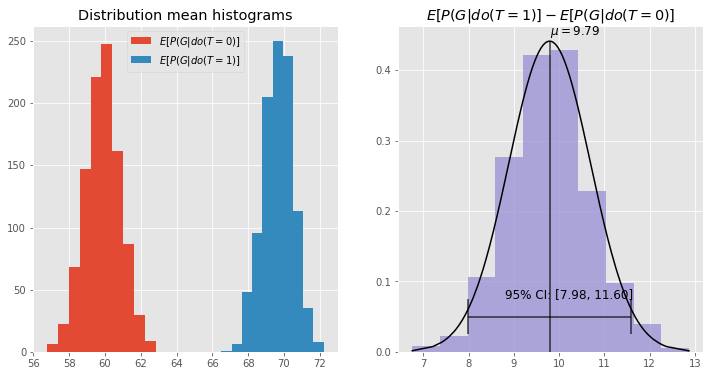

In [442]:
large_bootstrap_results = boostrap_backdoor_estimate(data, 'G', 'T', 'M', 1000, 200)
labels_to_results['Full data, large bootstrap'] = large_bootstrap_results

Nicely, as we would expect, the uncertainty also narrows, and the value approaches closer to the difference of distribution means approximated above, to which we would expect the bootstrap samples to converge. 

## Estimating the treatment effect using linear regression:

We can use the standard error estimates to get a confidence interval here 'for free', without bootstrapping:

In [446]:
def linear_regression_effect_estimate(data, output, treatment, backdoor):
    linear_model = sm.OLS(data[output], sm.add_constant(data[[treatment, backdoor]]))
    result = linear_model.fit()
    print(result.summary())
    display(Markdown(f'Estimated causal effect: {result.params[treatment]:.2f}'))
    display(Markdown(f'95% CI: [{result.params[treatment] - 2 * result.bse[treatment]:.2f}, {result.params[treatment] + 2 * result.bse[treatment]:.2f}]'))
    return result

linear_result = linear_regression_effect_estimate(data, 'G', 'T', 'M')
labels_to_results['Full data, regression'] = linear_result

                            OLS Regression Results                            
Dep. Variable:                      G   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     2418.
Date:                Sat, 03 Nov 2018   Prob (F-statistic):               0.00
Time:                        14:47:47   Log-Likelihood:                -3186.3
No. Observations:                1000   AIC:                             6379.
Df Residuals:                     997   BIC:                             6393.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.1393      0.308    162.617      0.0

Estimated causal effect: 9.95

95% CI: [9.13, 10.77]

## Conditioning to create a collider bias

Following some of the examples (of what _not_ to do) in the Elwert & Winship (2014) paper we reviewed in week 7, is to truncate our sample by a collider response variable. In our case, the appropriate variable would be $R$, the rating students gave the course. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a24f1f6a0>]],
      dtype=object)

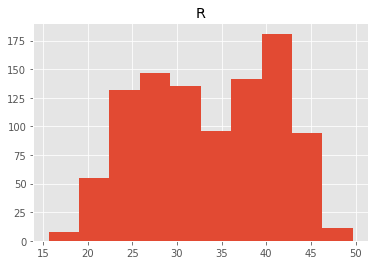

In [344]:
data.hist('R')

For one example, let's look separately at the students who gave the bottom half of ratings, and those who gave the top half:

In [390]:
cutoff = sorted(data.R)[int(len(data) / 2)]

truncated_lower_data = data[data.R < cutoff]
truncated_upper_data = data[data.R >= cutoff]
len(truncated_lower_data), len(truncated_upper_data)

(500, 500)

Let us repeat some of the prior work with this truncated sample.

### Kernel-density based backdoor adjustment:

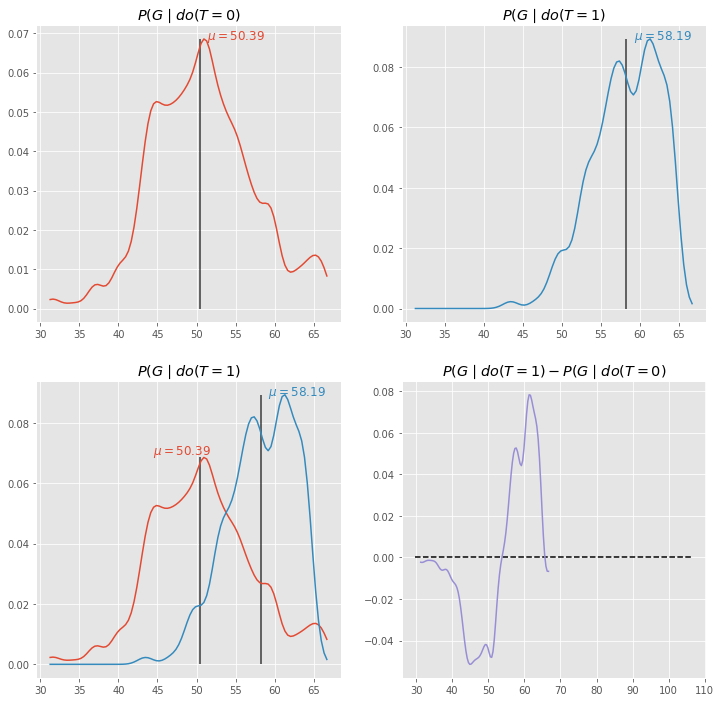

The difference in means is:

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

The variances (second moment estimates) and standard deviations are:

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

The middle 50% of each distribution is:

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [382]:
lower_backdoor_treat_0, lower_backdoor_treat_1, lower_plot_values, lower_dx = \
    compute_and_plot_backdoor_kernel(truncated_lower_data, 'G', 'T', 'M')

### Bootstrap-based estimate

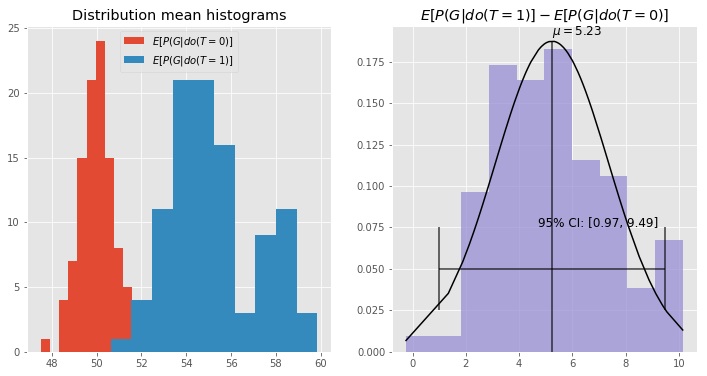

In [444]:
lower_bootstrap_results = boostrap_backdoor_estimate(truncated_lower_data, 'G', 'T', 'M', 100, 100)
labels_to_results['Lower half data, small bootstrap'] = lower_bootstrap_results

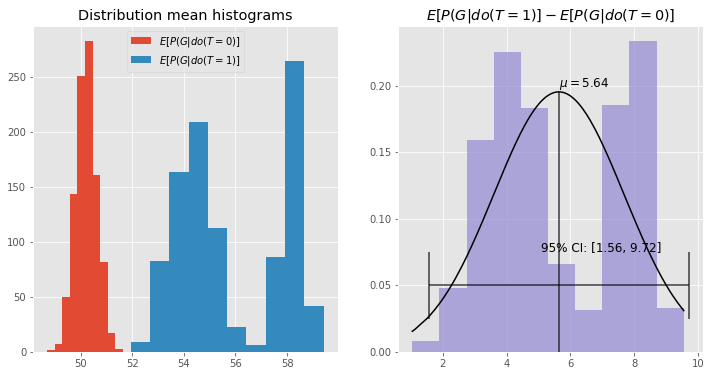

In [445]:
large_lower_bootstrap_results = boostrap_backdoor_estimate(truncated_lower_data, 'G', 'T', 'M', 1000, 200)
labels_to_results['Lower half data, large bootstrap'] = large_lower_bootstrap_results

Elegantly, this plot of bootstrap samples should also be alerting us to the fact that something is wrong -- under reasonable conditions, we expect the bootstarp distribution to be unimodal and approximately normal, but the distribution for $T = 1$ (and hence, also for the difference) appears strongly bimodal, which 'smells' wrong. We would expect to see the same thing happen for $T = 0$ in the other half of the data later:

### Linear regression estimate

In [447]:
labels_to_results['Lower half data, regression'] = \
    linear_regression_effect_estimate(truncated_lower_data, 'G', 'T', 'M')

                            OLS Regression Results                            
Dep. Variable:                      G   R-squared:                       0.427
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                     184.9
Date:                Sat, 03 Nov 2018   Prob (F-statistic):           9.22e-61
Time:                        14:48:16   Log-Likelihood:                -1527.6
No. Observations:                 500   AIC:                             3061.
Df Residuals:                     497   BIC:                             3074.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.0114      0.295    169.539      0.0

Estimated causal effect: 7.77

95% CI: [6.78, 8.76]

Unsurprisingly, when we condition on students with lower ratings, it biases our estimate. Let's repeat with the other half and see if we recover a similar effect: 

### Kernel-density based backdoor adjustment:

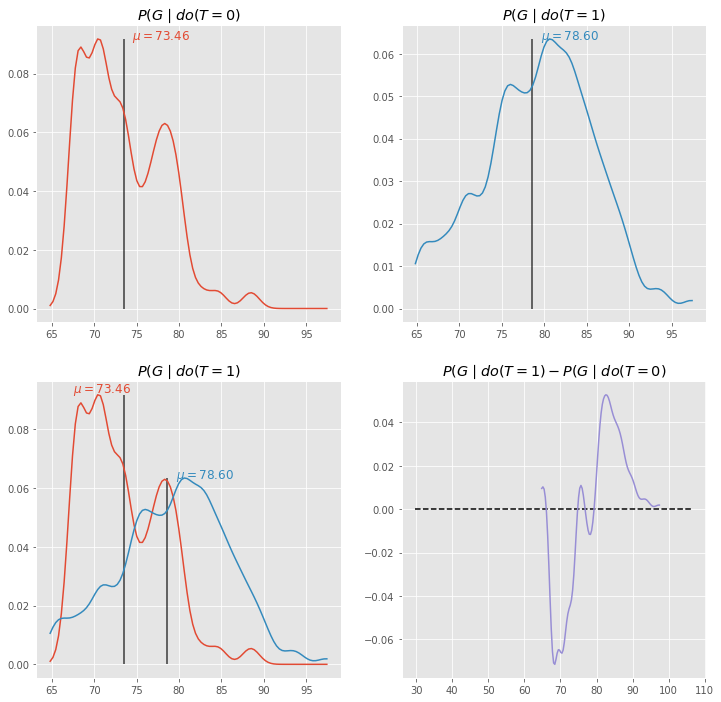

The difference in means is:

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

The variances (second moment estimates) and standard deviations are:

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

The middle 50% of each distribution is:

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [391]:
upper_backdoor_treat_0, upper_backdoor_treat_1, upper_plot_values, upper_dx = \
    compute_and_plot_backdoor_kernel(truncated_upper_data, 'G', 'T', 'M')

### Bootstrap-based estimate

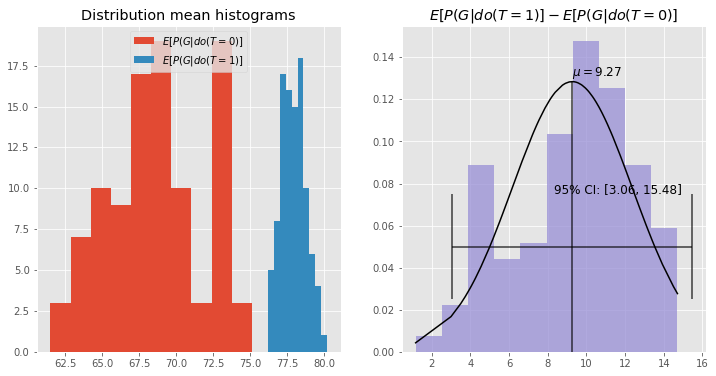

In [448]:
upper_bootstrap_results = boostrap_backdoor_estimate(truncated_upper_data, 'G', 'T', 'M', 100, 100)
labels_to_results['Upper half data, small bootstrap'] = upper_bootstrap_results

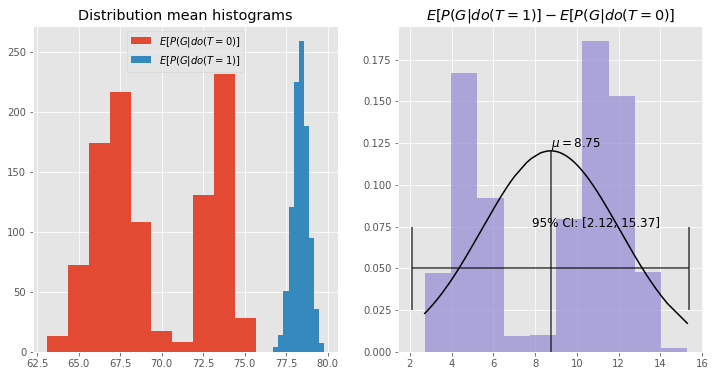

In [449]:
large_upper_bootstrap_results = boostrap_backdoor_estimate(truncated_upper_data, 'G', 'T', 'M', 1000, 200)
labels_to_results['Upper half data, large bootstrap'] = large_upper_bootstrap_results

Indeed, in this case the distribution for $T = 0$ is bimodal, once again leading the bootstrap samples to fail to converge to anything resembling a normal distribution. 

### Linear regression estimate

In [451]:
labels_to_results['Upper half data, regression'] = \
    linear_regression_effect_estimate(truncated_upper_data, 'G', 'T', 'M')

                            OLS Regression Results                            
Dep. Variable:                      G   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     130.9
Date:                Sat, 03 Nov 2018   Prob (F-statistic):           2.11e-46
Time:                        14:49:18   Log-Likelihood:                -1541.3
No. Observations:                 500   AIC:                             3089.
Df Residuals:                     497   BIC:                             3101.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         62.5237      1.023     61.110      0.0

Estimated causal effect: 6.23

95% CI: [4.84, 7.62]

## Let's push this example further to the extreme

Just to really hammer home why this is problematic, let's say that our institution decided to focus only on the students who gave the most extreme answers, perhaps the top 20% and the bottom 20%. Let's see how that might go wrong.

One immediate way where it goes wrong is that it's likely to completley omit some parts of the distribution of $M$, our backdoor variable, or of $T$, our effect/treatment variable. This requires adding some robustness to the backdoor and bootstrap routines above, which I did:

In [396]:
r_sorted = sorted(data.R)
low_cutoff = r_sorted[int(len(data) * 0.2)]
high_cutoff = r_sorted[int(len(data) * 0.8)]

extreme_lower_data = data[data.R < low_cutoff]
extreme_upper_data = data[data.R >= high_cutoff]
len(extreme_lower_data), len(extreme_upper_data)

(200, 200)

## Extreme lower end of data

### Kernel-density based backdoor adjustment:

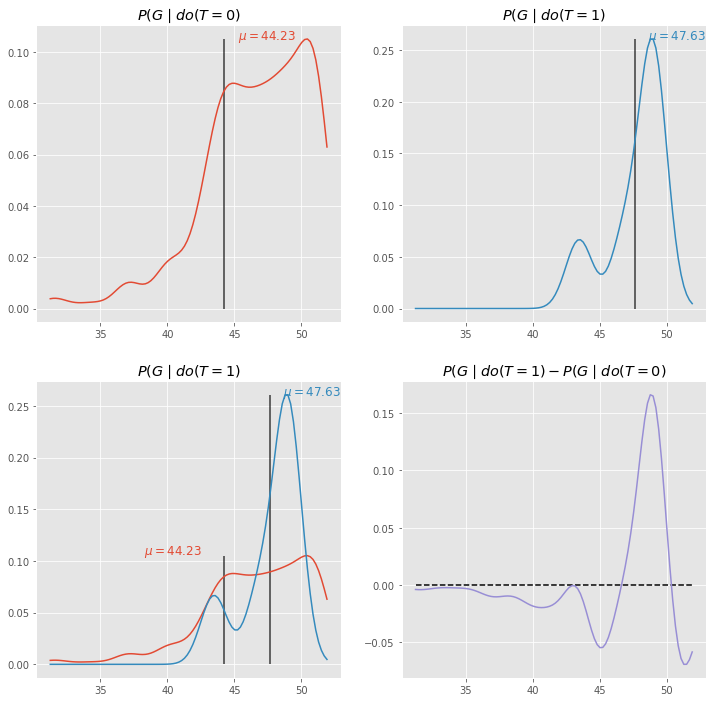

The difference in means is:

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

The variances (second moment estimates) and standard deviations are:

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

The middle 50% of each distribution is:

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [402]:
lower_backdoor_treat_0, lower_backdoor_treat_1, lower_plot_values, lower_dx = \
    compute_and_plot_backdoor_kernel(extreme_lower_data, 'G', 'T', 'M')

### Bootstrap-based estimate

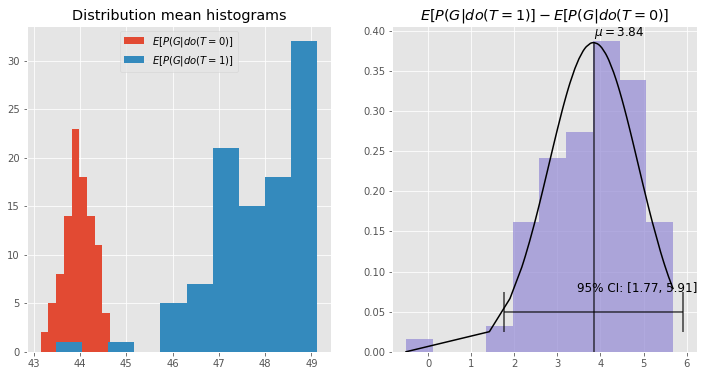

In [452]:
ex_lower_bootstrap_results = boostrap_backdoor_estimate(extreme_lower_data, 'G', 'T', 'M', 100, 100)
labels_to_results['Lower 20%, small bootstrap'] = ex_lower_bootstrap_results

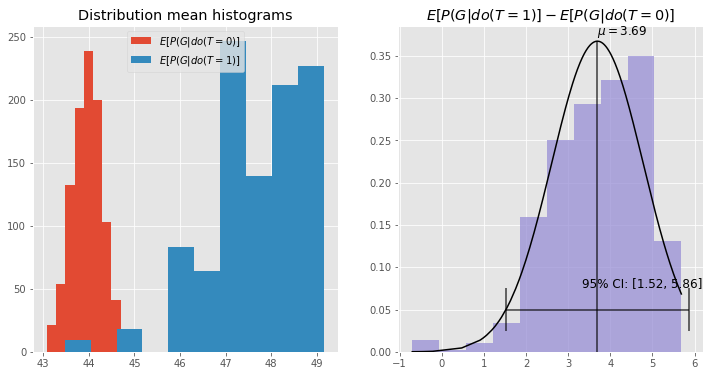

In [453]:
large_ex_lower_bootstrap_results = boostrap_backdoor_estimate(extreme_lower_data, 'G', 'T', 'M', 1000, 100)
labels_to_results['Lower 20%, large bootstrap'] = large_ex_lower_bootstrap_results

Distressingly, the previous example at least pointed us to the fact that this appeared non-normal. This example appear rather reasonable distributionally. The fact I had to add some robustness measures to the bootstrap codes hints at sampling problems, but if I had a preexisting routine, I would not have run into those issues. Even with the larger number of bootstrap samples, our confidence interval is rather wide, with some bootstrap samples even showing an effect of about zero.

### Linear regression estimate

In [454]:
labels_to_results['Lower 20%, regression'] = \
    linear_regression_effect_estimate(extreme_lower_data, 'G', 'T', 'M')

                            OLS Regression Results                            
Dep. Variable:                      G   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.4314
Date:                Sat, 03 Nov 2018   Prob (F-statistic):              0.512
Time:                        14:50:48   Log-Likelihood:                -555.70
No. Observations:                 200   AIC:                             1115.
Df Residuals:                     198   BIC:                             1122.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         46.6226      0.281    165.905      0.0

/Users/guydavidson/anaconda/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1633: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/guydavidson/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/Users/guydavidson/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/guydavidson/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/guydavidson/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Estimated causal effect: 1.07

95% CI: [-2.18, 4.31]

Linear regression also hints at problems. The uniformity in $M$ meant it failed to estimate a regression coefficient for it, and the estimate for $T$ is substantially lower than the one generated by the backdoor estimator, and with a much wider standard error.

Interestingly, while they're both off, the backdoor estimate is closer (although not really close at all) to the correct effect. 

## Extreme upper end of data

### Kernel-density based backdoor adjustment:

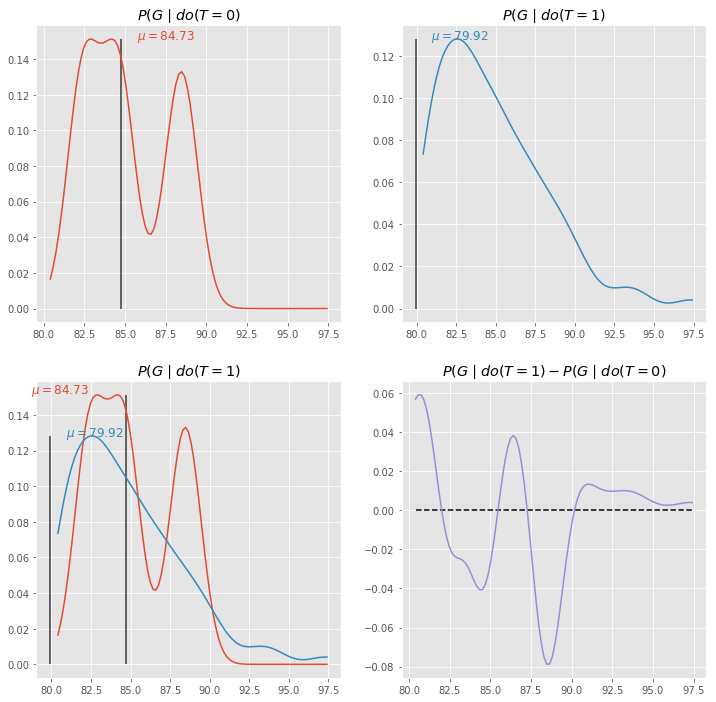

The difference in means is:

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

The variances (second moment estimates) and standard deviations are:

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

The middle 50% of each distribution is:

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [424]:
ex_upper_backdoor_treat_0, ex_upper_backdoor_treat_1, ex_upper_plot_values, ex_upper_dx = \
    compute_and_plot_backdoor_kernel(extreme_upper_data, 'G', 'T', 'M')

### Bootstrap-based estimate

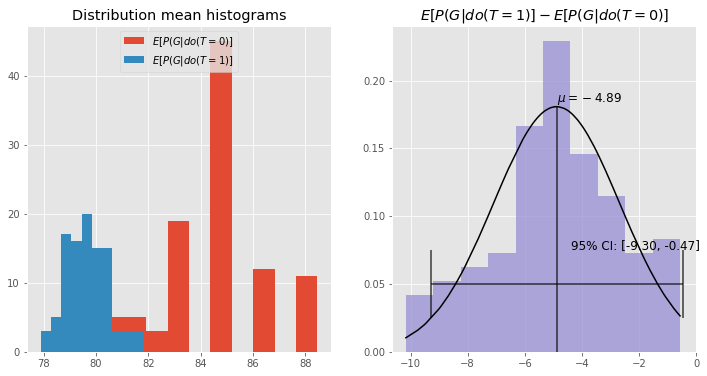

In [455]:
ex_upper_bootstrap_results = boostrap_backdoor_estimate(extreme_upper_data, 'G', 'T', 'M', 100, 100)
labels_to_results['Upper 20%, small bootstrap'] = ex_upper_bootstrap_results

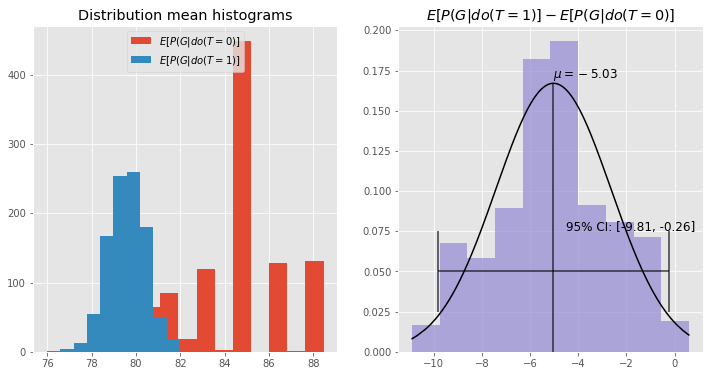

In [456]:
large_ex_upper_bootstrap_results = boostrap_backdoor_estimate(extreme_upper_data, 'G', 'T', 'M', 1000, 100)
labels_to_results['Upper 20%, large bootstrap'] = large_ex_upper_bootstrap_results

In [430]:
sum(extreme_upper_data['T'] == 0)

3

One last interesting failure case: the bootstrap samples for $T = 0$ look rather awful - there's no reason for the means to jump around between values as they're doing, other than trying to generate means from extremley little data. The above summation shows why, as only three of those exist. This causes the causal effect estimate to jump completley in the wrong direction. The indicator in this case would be the samll data - it's effectively impossible to determine the effect of this variable when we have so few points with it being 0.

### Linear regression estimate

In [457]:
labels_to_results['Upper 20%, regression'] = \
    linear_regression_effect_estimate(extreme_upper_data, 'G', 'T', 'M')

                            OLS Regression Results                            
Dep. Variable:                      G   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                   0.03715
Date:                Sat, 03 Nov 2018   Prob (F-statistic):              0.847
Time:                        14:52:15   Log-Likelihood:                -525.94
No. Observations:                 200   AIC:                             1056.
Df Residuals:                     198   BIC:                             1062.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
T             -0.3782      1.962     -0.193      0.8

Estimated causal effect: -0.38

95% CI: [-4.30, 3.55]

Linear regression also recovers find a negative effect, albeit it is much less certain than about it (and far closer to 0) than M is. 

## Final result visualization

In [459]:
labels_to_results.keys()

odict_keys(['Full data, small bootstrap', 'Full data, large bootstrap', 'Full data, regression', 'Lower half data, small bootstrap', 'Lower half data, large bootstrap', 'Lower half data, regression', 'Upper half data, small bootstrap', 'Upper half data, large bootstrap', 'Upper half data, regression', 'Lower 20%, small bootstrap', 'Lower 20%, large bootstrap', 'Lower 20%, regression', 'Upper 20%, small bootstrap', 'Upper 20%, large bootstrap', 'Upper 20%, regression'])

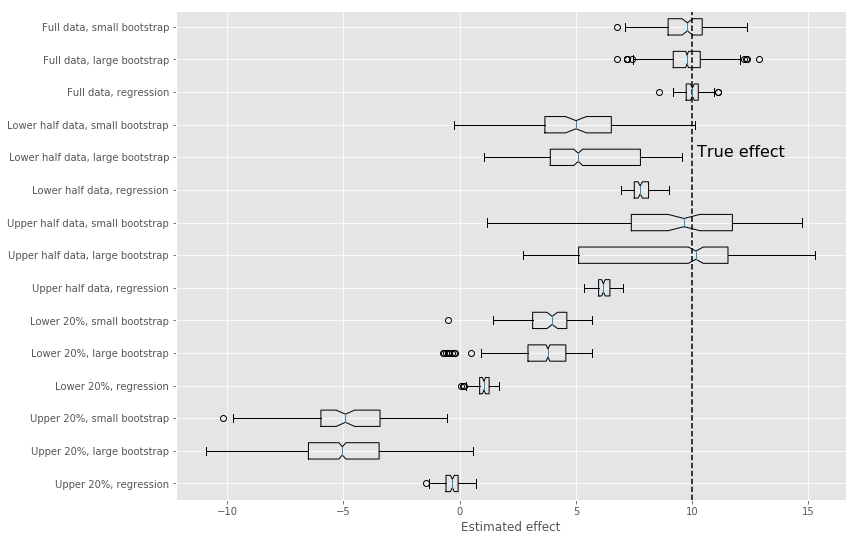

In [483]:
N_RANDOM_REGRESSION_POINTS = 100


plt.figure(figsize=(12, 9))

x = []
labels = []

for label in reversed(labels_to_results):
    results = labels_to_results[label]
    
    # bootstrap results
    if isinstance(results, list):
        treat_0_means = np.array([tup[0].mean for tup in results])
        treat_1_means = np.array([tup[1].mean for tup in results])
        x.append(treat_1_means - treat_0_means)
        
    # regression results
    # note that in order to visualize regerssion results, I sample some data from 
    # a normal distribution with a mean around the regression coefficient and the appropriate se
    else:
        est = results.params['T']
        se = result.bse['T']
        x.append(np.random.normal(est, se, N_RANDOM_REGRESSION_POINTS))
    
    labels.append(label)
    

plt.boxplot(x, labels=labels, vert=False, notch=True)
plt.vlines(10, 0, len(labels_to_results) + 1, linestyle='--')
plt.text(10.2, 11, 'True effect', fontsize=16)
plt.xlabel('Estimated effect')
plt.show()


## Final conclusions
Some of these were mentioned above to some degree, but:

1. Both the bootstraped distribution estimate around the backdoor adjustment and the regression model capture the effeect well on the full data, assuming the relevant variables are both conditioned upon in the backdoor and included in the regression model.

2. With partial data selected in a manner that conditions on a collider, the true effect fails to recover in at least some of the cases. Only one case succeeds -- the upper half (by $R$, the collider) of the data, probably because the model is additive in the effects of the backdoor variable ($M$) and the variable of interest ($T$), and both have positive effects, allowing the subsample to be reasonably less biased. 

3. Bootstrapping and plotting the distributions allows for interesting diagnostics of a number of failure modes: 

    * Bi-modality (or other non-normality) in the bootstrapped means (leading to bimodality of bootsrapped effect estimates).
    
    * Undersmpling of one condition leading to sparsity in the boostrapped distribution.
    
    * Failure modes where some subsample of the population is omitted from a bootstrap sample (no representation for a particular value of the backdoor variable, the variable of interest, or both).

    * _Note that all of these were easier to capture since in this case both there is a single backdoor variable, and both it and the variable of interest are binary. If they took multiple discrete values, this would be trickier to analyze, and yet again in the case of continuous variables._
    
4. Regression failed to capture the effect in the one collided subsample that the backdoor adjustment succeeded in. Otherwise, in some cases the regression estimates were lower than the backdoor adjusted ones, and in some cases higher, without a clear pattern. In the most extreme case, of only the upper 20% (by $R$) of the data, tregression failed less miserably, at least predicting a null effect rather than one with the opposite sign. 

5. I guess I am not surprised that the collided subsample estimates tend to underestimate the true effect, since they cannot separate out the backdoor effect as well as the full data can, and both are additive and positive. The case of the upper most 20% is fascinating, and shows what a few outliers can do to an effect estimate. 

6. While this work treated two of the variables as binary, it could be extended to more continuous variables. If the variable of interest ($T$) was continuous, we could estimate two-dimensional densities in $T, G$ for every value of $T$, and attempt to use something akin to Pearl's equation for the slope of the total effect (4.17) evaluated at different points or averaged over the entire distribution. If the backdoor variable $M$ was continuous as well, we would have to integrate rather than sum over it, which would mean approximating the integral by binning and summing.

    * _I imagine that binning and summing over is the standard approach, rather than using a kernel density, but this seemed more interesting to play with, and equally valid, I hope._